In [12]:
import os, sys, glob, shutil, json
import cv2

from PIL import Image
from PIL import ImageChops
from PIL import ImageFilter
import numpy as np

from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data.dataset import Dataset
from tensorboardX import SummaryWriter   # tensorboard
import torchvision.transforms as transforms


print(torch.__version__)
print(torch.cuda.is_available())

1.7.0+cu101
True


## no data augmentation

In [13]:
train_path = glob.glob('../input/mchar_train/*.png')
train_path.sort()
train_json = json.load(open('../input/mchar_train.json'))
train_label = [train_json[x]['label'] for x in train_json]

val_path = glob.glob('../input/mchar_val/*.png')
val_path.sort()
val_json = json.load(open('../input/mchar_val.json'))
val_label = [val_json[x]['label'] for x in val_json]

# BATCH_SIZE = 10
BATCH_SIZE = 1000

## train dataset augmentation

In [10]:
# 训练集样本加权
train_json = json.load(open('../input/mchar_train.json'))
train_label = []
train_path = []
for x in train_json:
    if len(train_json[x]['label']) in [1,2,4]:
        train_label.append(train_json[x]['label'])
        train_path.append(os.path.join('../input/mchar_train',x))
    if len(train_json[x]['label']) in [3]:
        train_label.append(train_json[x]['label'])
        train_label.append(train_json[x]['label'])
        train_path.append(os.path.join('../input/mchar_train',x))
        train_path.append(os.path.join('../input/mchar_train',x))


val_path = glob.glob('../input/mchar_val/*.png')
val_path.sort()
val_json = json.load(open('../input/mchar_val.json'))
val_label = [val_json[x]['label'] for x in val_json]

# BATCH_SIZE = 10
BATCH_SIZE = 1000

# dataset

In [14]:
class SVHNDataset(Dataset):
    def __init__(self, img_path, img_label, transform=None, train=True, test=False):
        self.img_path = img_path
        self.img_label = img_label
        self.train = train
        self.test = test
        if transform is not None:
            self.transform = transform
        else:
            self.transform = None

    def __getitem__(self, index):
        img = Image.open(self.img_path[index]).convert('RGB')
        
        if self.train and not self.test:
            img = img.resize((128, 64))
            img = ImageChops.offset(img, np.random.randint(-35, 35), np.random.randint(-10, 10))  # 平移
            if np.random.randint(2):
                # img = np.array(img)
                # img = util.random_noise(img, mode='gaussian')  # 添加噪声
                # img = np.uint8(img*255);
                # img = Image.fromarray(img)
                img = img.filter(ImageFilter.BLUR)  # 图像模糊

        if self.transform is not None:
            img = self.transform(img)
        
        if self.img_label == None:
            return img
        else:
            # 原始SVHN中类别10为填充的数字X, 最多字符为6
            lbl = np.array(self.img_label[index], dtype=np.int)
            lbl = list(lbl)  + (4 - len(lbl)) * [10]
            return img, torch.from_numpy(np.array(lbl[:4]))

    def __len__(self):
        return len(self.img_path)


train_loader = torch.utils.data.DataLoader(
        SVHNDataset(train_path, train_label,
                   transforms.Compose([
                       transforms.Resize((64, 128)),
                       transforms.RandomCrop((60, 120)),
                       transforms.ColorJitter(0.3, 0.3, 0.2),
                       transforms.RandomRotation(10),
                       transforms.ToTensor(),
                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),train=True, test=False), 
    batch_size=BATCH_SIZE, # 每批样本个数
    shuffle=True, # 是否打乱顺序
    num_workers=10, # 读取的线程个数
)

    
val_loader = torch.utils.data.DataLoader(
    SVHNDataset(val_path, val_label,
                    transforms.Compose([
#                        transforms.Resize((64, 128)),
                        transforms.Resize((60, 120)),
                    #    transforms.ColorJitter(0.3, 0.3, 0.2),
                    #    transforms.RandomRotation(5),
                       transforms.ToTensor(),
                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]), train=False, test=True), 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=10, 
)

In [15]:
# 定义模型
class SVHN_Model1(nn.Module):
    def __init__(self):
        super(SVHN_Model1, self).__init__()
        # CNN提取特征模块
#         self.cnn = nn.Sequential(
#             nn.Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2)),
#             nn.ReLU(),  
#             nn.MaxPool2d(2),
#             nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2)),
#             nn.ReLU(), 
#             nn.MaxPool2d(2),
#         )
#         # 
#         self.fc1 = nn.Linear(32*3*7, 11)
#         self.fc2 = nn.Linear(32*3*7, 11)
#         self.fc3 = nn.Linear(32*3*7, 11)
#         self.fc4 = nn.Linear(32*3*7, 11)

         # CNN，提取特征
        model_conv = models.resnet34(pretrained=True)
        model_conv.avgpool = nn.AdaptiveAvgPool2d(1)  # 更改了resnet中的avgpool层
        model_conv = nn.Sequential(*list(model_conv.children())[:-1])  # children获得网络的子层，list封装一下，[:-1]遍历全部元素
        self.cnn = model_conv

        # 全连接网络，分类
        self.fc1 = nn.Linear(512, 11)
        self.fc2 = nn.Linear(512, 11)
        self.fc3 = nn.Linear(512, 11)
        self.fc4 = nn.Linear(512, 11)
#         self.fc5 = nn.Linear(512, 11)
    
    def forward(self, img):        
        feat = self.cnn(img)
        feat = feat.view(feat.shape[0], -1)
        c1 = self.fc1(feat)
        c2 = self.fc2(feat)
        c3 = self.fc3(feat)
        c4 = self.fc4(feat)
#         c5 = self.fc5(feat)
        return c1, c2, c3, c4
#         return c1, c2, c3, c4, c5

In [18]:
def train(train_loader, model, criterion, optimizer, epoch):
    # 切换模型为训练模式
    model.train()
    train_loss = []

    for (data, label) in tqdm(train_loader):
        data = data.cuda()
        label = label.cuda()
        c0, c1, c2, c3 = model(data)
#         c0, c1, c2, c3, c4 = model(data)
#         loss = 2*criterion(c0, label[:, 0]) + \
#                 criterion(c1, label[:, 1]) + \
#                 2*criterion(c2, label[:, 2]) + \
#                 criterion(c3, label[:, 3])
        
        loss = criterion(c0, label[:, 0]) + \
                criterion(c1, label[:, 1]) + \
                criterion(c2, label[:, 2]) + \
                criterion(c3, label[:, 3]) 
        
        loss /= (4*BATCH_SIZE)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
    return np.mean(train_loss)


def validate(val_loader, model, criterion):
    # 切换模型为预测模型
    model.eval()
    val_loss = []
    val_predict = []

    # 不记录模型梯度信息
    with torch.no_grad():
        for (data, label) in tqdm(val_loader):
            data = data.cuda()
            label = label.cuda()
            c0, c1, c2, c3 = model(data)
            # print(c0.shape)
            loss = criterion(c0, label[:, 0]) + \
                    criterion(c1, label[:, 1]) + \
                    criterion(c2, label[:, 2]) + \
                    criterion(c3, label[:, 3]) 
            loss /= (4*BATCH_SIZE)
            val_loss.append(loss.item())
            
            # calculate validation accuracy
            output = np.concatenate([
                c0.data.cpu().numpy(),
                c1.data.cpu().numpy(),
                c2.data.cpu().numpy(),
                c3.data.cpu().numpy()], axis=1)# output: shape(batch, 44)
            val_predict.append(output)        
        val_predict = np.vstack(val_predict)
        
        val_predict = np.vstack([
            val_predict[:, :11].argmax(1),
            val_predict[:, 11:22].argmax(1),
            val_predict[:, 22:33].argmax(1),
            val_predict[:, 33:44].argmax(1)]).T
        val_predict_label = list()
        for x in val_predict:
            val_predict_label.append(''.join(map(str, x[x!=10])))
        val_label = [''.join(map(str, x)) for x in val_loader.dataset.img_label]
        val_acc = np.mean(np.array(val_predict_label) == np.array(val_label))
    return np.mean(val_loss), val_acc

In [19]:
# load model
# model.load_state_dict(torch.load('model_end.pt'))


torch.manual_seed(0)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True

model = SVHN_Model1().cuda()
# 损失函数
criterion = nn.CrossEntropyLoss(size_average=False)
# 优化器
optimizer = torch.optim.Adam(model.parameters(), 0.001, weight_decay=0.0005)
best_loss = 1000.0


train_loss_plot = list()
val_loss_plot = list()
val_acc_plot = list()

# writer = SummaryWriter('log')
writer = SummaryWriter()

from datetime import datetime
now = datetime.now()

for epoch in range(40):
    print('\nEpoch: ', epoch)
    if epoch == 15: optimizer = torch.optim.Adam(model.parameters(), 0.0001, weight_decay=0.0005)
    if epoch == 25: optimizer = torch.optim.Adam(model.parameters(), 0.00001, weight_decay=0.0005)
    if epoch == 35: optimizer = torch.optim.Adam(model.parameters(), 0.00001, weight_decay=0.0005)

    train_loss = train(train_loader, model, criterion, optimizer, epoch)
    val_loss, val_acc = validate(val_loader, model, criterion)# val_predict: shape(10000, 44)

    
    # 记录下验证集精度
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), './model_best.pt')
    
    train_loss_plot.append(train_loss)
    val_loss_plot.append(val_loss)
    val_acc_plot.append(val_acc)
    writer.add_scalar('Loss/train', float(train_loss), epoch)
    writer.add_scalar('Loss/validation', float(val_loss), epoch)
    writer.add_scalar('val_acc', float(val_acc), epoch)

writer.close()
torch.save(model.state_dict(), './model_end.pt')

print("\nruning time:", datetime.now() - now)

  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  0


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  1


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  2


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  3


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  4


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  5


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  6


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  7


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  8


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  9


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  10


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  11


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  12


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  13


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  14


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  15


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  16


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  17


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  18


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  19


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  20


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  21


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  22


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  23


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  24


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  25


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  26


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  27


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  28


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  29


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  30


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  31


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  32


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  33


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  34


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  35


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  36


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  37


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  38


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  39


100%|██████████| 10/10 [00:03<00:00,  3.24it/s]



runing time: 0:09:15.506238


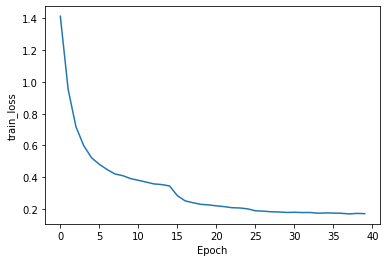

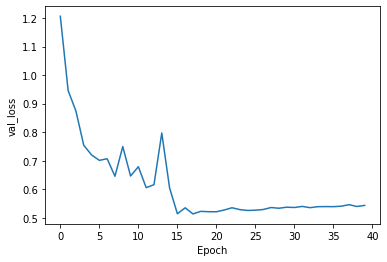

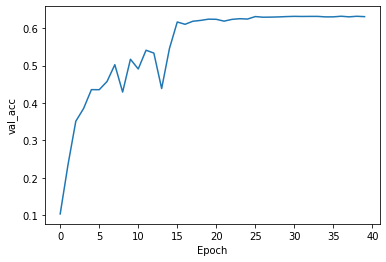


train_loss: [1.4138780236244202, 0.9540530025959015, 0.718463824192683, 0.5987216095129649, 0.5228297621011734, 0.4812906493743261, 0.4486372927824656, 0.4204266170660655, 0.40990484654903414, 0.39145979781945545, 0.3805737892786662, 0.36950455208619437, 0.35799051920572916, 0.3538849691549937, 0.34515491922696434, 0.2838618258635203, 0.25108953515688576, 0.2395820160706838, 0.22936189969380696, 0.22596035053332647, 0.2197904571890831, 0.21501683741807937, 0.20814049641291302, 0.2064920018116633, 0.20080435077349346, 0.1888312871257464, 0.18648216674725215, 0.18252838750680286, 0.18134481559197108, 0.17826632112264634, 0.1793597290913264, 0.17758249938488008, 0.17806090513865153, 0.1733140582839648, 0.17514314353466034, 0.17440137614806492, 0.1731198032697042, 0.1690573513507843, 0.17229224095741907, 0.17080072661240894] 

max: 1.4138780236244202

val_loss: [1.2059329748153687, 0.9458357512950897, 0.8739173233509063, 0.754520034790039, 0.7205553352832794, 0.7015215516090393, 0.7071173

In [20]:
plt.plot(train_loss_plot)
plt.xlabel("Epoch")
plt.ylabel("train_loss")
plt.show()

plt.plot(val_loss_plot)
plt.xlabel("Epoch")
plt.ylabel("val_loss")
plt.show()

plt.plot(val_acc_plot)
plt.xlabel("Epoch")
plt.ylabel("val_acc")
plt.show()

print("\ntrain_loss:", train_loss_plot, "\n\nmax:", max(train_loss_plot))
print("\nval_loss:", val_loss_plot, "\n\nmax:", max(val_loss_plot))
print("\nval_acc:", val_acc_plot, "\n\nmax:", max(val_acc_plot))


next 待测试

In [14]:
test_path = glob.glob('../input/mchar_test_a/*.png')
test_path.sort()
test_label = None


test_loader = torch.utils.data.DataLoader(
        SVHNDataset(test_path, test_label,
                   transforms.Compose([
                       transforms.Resize((60, 120)),
                    #    transforms.ColorJitter(0.3, 0.3, 0.2),
                    #    transforms.RandomRotation(5),
                       transforms.ToTensor(),
                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]), train=False, test=True), 
    batch_size=BATCH_SIZE, # 每批样本个数
    shuffle=False, # 是否打乱顺序
    num_workers=10, # 读取的线程个数
)


def predict(test_loader, model):
    model.eval()

    test_pred = []
    with torch.no_grad():
        for input in tqdm(test_loader):
            input = input.cuda()

            c0, c1, c2, c3 = model(input)
            output = np.concatenate([
                c0.data.cpu().numpy(),
                c1.data.cpu().numpy(),
                c2.data.cpu().numpy(),
                c3.data.cpu().numpy()], axis = 1)
            test_pred.append(output)
        test_pred = np.vstack(test_pred)
        test_pred = np.vstack([
            test_pred[:, :11].argmax(1),
            test_pred[:, 11:22].argmax(1),
            test_pred[:, 22:33].argmax(1),
            test_pred[:, 33:44].argmax(1)]).T
        
        test_predict_label = list()        
        for x in test_pred:
            test_predict_label.append(''.join(map(str, x[x!=10])))
    return test_predict_label


# load model
model.load_state_dict(torch.load('model_best.pt'))
submit = predict(test_loader, model)

100%|██████████| 40/40 [00:05<00:00,  6.73it/s]


In [19]:
import pandas as pd

df_submit = pd.read_csv('../input/mchar_sample_submit_A.csv')
df_submit['file_code'] = submit
df_submit.to_csv('submit.csv', index=None)
print("save success!")

save success!
